In [33]:
import tensorflow as tf
import os
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D
import cv2 as cv

In [34]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)

train_dir = "C:/Users/Timii/Documents/Dev/Zummit/fer_data/train"
test_dir = "C:/Users/Timii/Documents/Dev/Zummit/fer_data/test"


train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, batch_size=BATCH_SIZE,
                                                             image_size=IMG_SIZE, label_mode='categorical')

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,  batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE, label_mode='categorical')

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [35]:
class_names = train_dataset.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

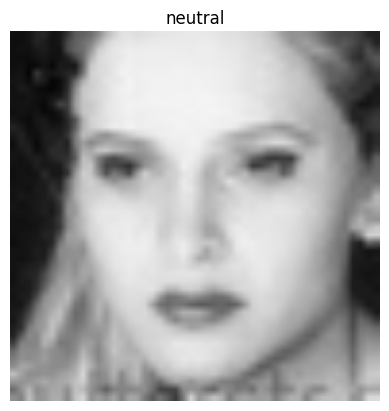

In [36]:
idx=1
for img, label in train_dataset.take(1):
    plt.imshow(img[idx].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(label[idx])])
    plt.axis("off")
    break

In [37]:
img[idx].shape

TensorShape([224, 224, 3])

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [39]:
data_augmenter = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2, 0.2),
#     tf.keras.layers.RandomTranslation(0.2, 0.2)
])

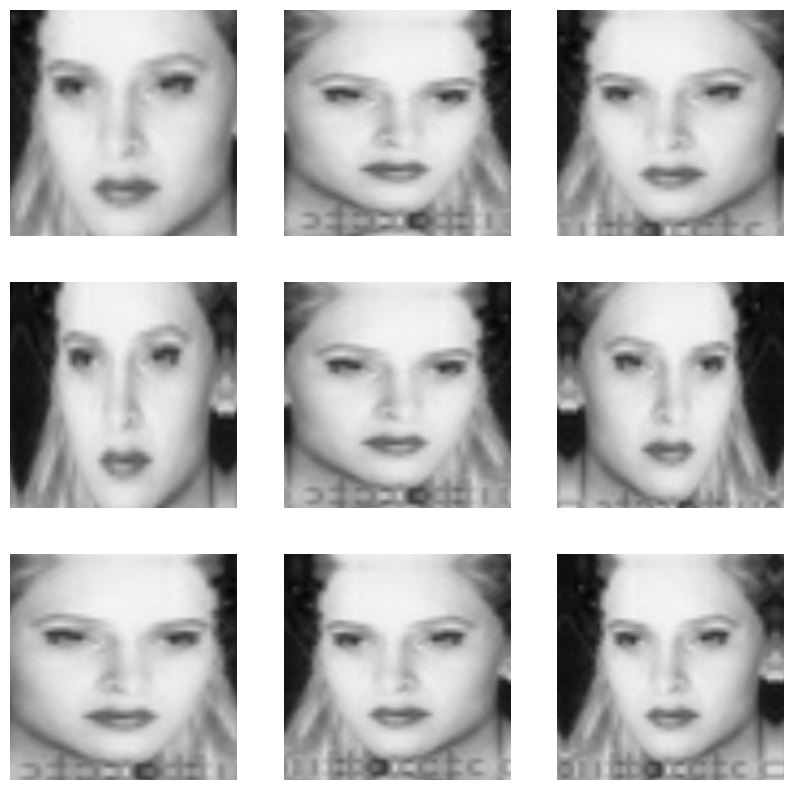

In [40]:
idx=1
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmenter(tf.expand_dims(img[idx], 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [41]:
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=IMG_SIZE+(3,),
    include_top=False,
    weights="imagenet",
    dropout_rate=0.2,
    include_preprocessing=True,
)

base_model.trainable = False 

In [42]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 576)


In [43]:
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

In [44]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 576)


In [45]:
prediction_layer = tf.keras.layers.Dense(7, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 7)


In [46]:
inputs = tf.keras.Input(shape=(IMG_SIZE+(3,))) 
x = data_augmenter(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(576, activation='relu')(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [47]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 576)               0         
                                                                 
 dense_3 (Dense)             (None, 576)               3323

In [48]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

initial_epochs = 5
history = model.fit(train_dataset, validation_data=test_dataset, epochs=initial_epochs)

Epoch 1/5
449/449 [==============================] - 627s 1s/step - loss: 1.5502 - accuracy: 0.4017 - val_loss: 1.4259 - val_accuracy: 0.4472
Epoch 2/5
449/449 [==============================] - 593s 1s/step - loss: 1.4463 - accuracy: 0.4462 - val_loss: 1.3530 - val_accuracy: 0.4823
Epoch 3/5
449/449 [==============================] - 599s 1s/step - loss: 1.4146 - accuracy: 0.4557 - val_loss: 1.3431 - val_accuracy: 0.4866
Epoch 4/5
449/449 [==============================] - 603s 1s/step - loss: 1.3857 - accuracy: 0.4700 - val_loss: 1.3227 - val_accuracy: 0.4972
Epoch 5/5
449/449 [==============================] - 605s 1s/step - loss: 1.3658 - accuracy: 0.4786 - val_loss: 1.3227 - val_accuracy: 0.4974


In [49]:
model.save('emotionNet.h5')

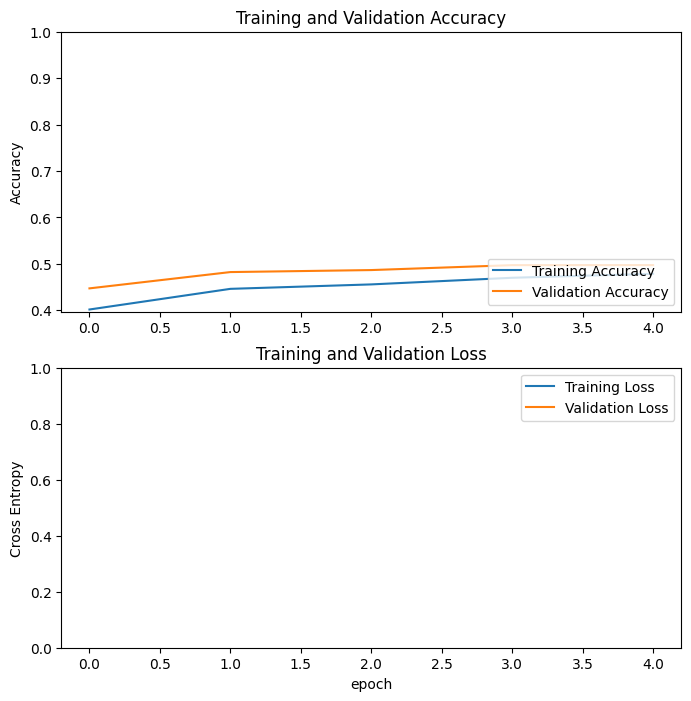

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [51]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  229


In [52]:
fine_tune_at = 150


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    

In [53]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 576)               0         
                                                                 
 dense_3 (Dense)             (None, 576)               3323

In [54]:
loss_function=tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.9*base_learning_rate)
metrics= ['accuracy']


model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)


fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset)              


Epoch 5/25
449/449 [==============================] - 816s 2s/step - loss: 1.1936 - accuracy: 0.5463 - val_loss: 1.0425 - val_accuracy: 0.6017
Epoch 6/25
449/449 [==============================] - 790s 2s/step - loss: 1.0309 - accuracy: 0.6092 - val_loss: 1.0294 - val_accuracy: 0.6141
Epoch 7/25
449/449 [==============================] - 790s 2s/step - loss: 0.9550 - accuracy: 0.6430 - val_loss: 0.9744 - val_accuracy: 0.6344
Epoch 8/25
449/449 [==============================] - 791s 2s/step - loss: 0.8893 - accuracy: 0.6688 - val_loss: 0.9594 - val_accuracy: 0.6417
Epoch 9/25
449/449 [==============================] - 794s 2s/step - loss: 0.8292 - accuracy: 0.6920 - val_loss: 0.9504 - val_accuracy: 0.6475
Epoch 10/25
449/449 [==============================] - 815s 2s/step - loss: 0.7821 - accuracy: 0.7067 - val_loss: 0.9505 - val_accuracy: 0.6570
Epoch 11/25
449/449 [==============================] - 822s 2s/step - loss: 0.7319 - accuracy: 0.7252 - val_loss: 0.9720 - val_accuracy: 0.66

In [55]:
model.save('emotionNet.h5')

In [56]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

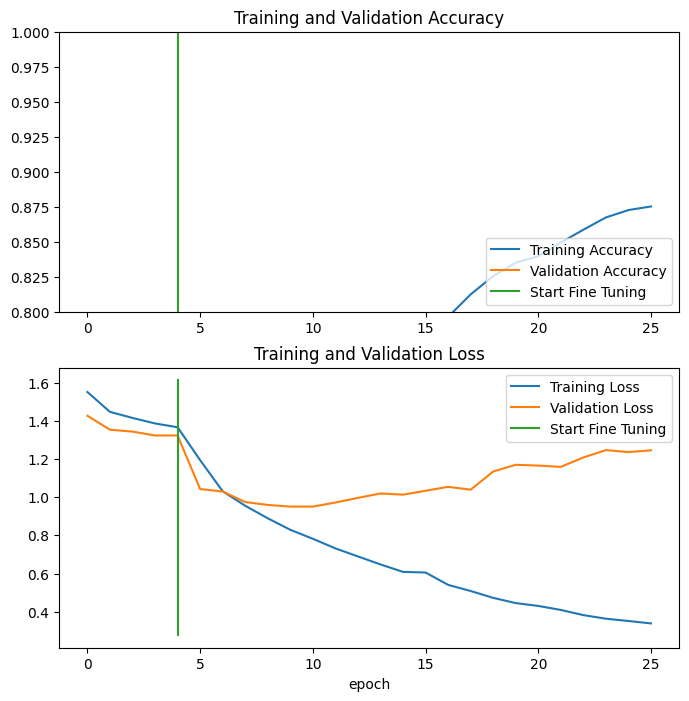

In [60]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [58]:
base_model.trainable = True

fine_tune_at = 100


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [59]:
loss_function=tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.01*base_learning_rate)
metrics= ['accuracy']

model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)


fine_tune_epochs2 = 10
total_epochs2 =  total_epochs + fine_tune_epochs2

history_fine2 = model.fit(train_dataset,
                         epochs=total_epochs2,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=test_dataset)  

Epoch 25/35
170/449 [==========>...................] - ETA: 10:51 - loss: 0.4110 - accuracy: 0.8496

KeyboardInterrupt: 

In [ ]:
acc += history_fine2.history['accuracy']
val_acc += history_fine2.history['val_accuracy']

loss += history_fine2.history['loss']
val_loss += history_fine2.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()